# **Data Preparation**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chintyaa27","key":"879f299bd4fd432e109c4c1496021ea0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
 99% 3.71G/3.75G [01:47<00:00, 49.0MB/s]
100% 3.75G/3.75G [01:47<00:00, 37.3MB/s]


In [ ]:
!unzip 140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [ ]:
import requests, os
from tqdm import tqdm

def download_fake_gan(dest='gan_new', total=500):
  os.makedirs(dest, exist_ok=True)
  for i in tqdm(range(total)):
    try:
      r = requests.get("https://thispersondoesnotexist.com/", headers={'Cache-Control': 'no-cache'}, timeout=5)
      with open(f"{dest}/face_{i:04d}.jpg", 'wb') as f:
        f.write(r.content)
    except Exception as e:
      print(f"Failed {i}: {e}")

download_fake_gan(dest="/content/fake_new", total=500)

100%|██████████| 500/500 [12:06<00:00,  1.45s/it]


In [ ]:
import os
import shutil
import random

def subset_copy(src_dir, dst_dir, n):
  os.makedirs(dst_dir, exist_ok=True)
  files = os.listdir(src_dir)
  sampled = random.sample(files, min(n, len(files)))
  for fname in sampled:
    shutil.copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

# Path dataset lama
src_base = '/content/real-vs-fake'

# Path dataset baru
dst_base = '/content/real-vs-fake-finetune'

# BUAT TRAIN FOLDER (1000 real + 1000 fake lama)
subset_copy(f'{src_base}/train/real', f'{dst_base}/train/real', 1000)
subset_copy(f'{src_base}/train/fake', f'{dst_base}/train/fake', 1000)

# BUAT VALID FOLDER (500 real + 500 fake lama)
subset_copy(f'{src_base}/valid/real', f'{dst_base}/valid/real', 500)
subset_copy(f'{src_base}/valid/fake', f'{dst_base}/valid/fake', 500)

In [ ]:
gan_all = os.listdir('/content/fake_new')

train_gan = gan_all[:400]
valid_gan = gan_all[400:500]

for fname in train_gan:
  shutil.copy(f'/content/fake_new/{fname}', f'{dst_base}/train/fake/{fname}')

for fname in valid_gan:
  shutil.copy(f'/content/fake_new/{fname}', f'{dst_base}/valid/fake/{fname}')


In [ ]:
shutil.make_archive('real-vs-fake-finetune', 'zip', 'real-vs-fake-finetune')

'/content/real-vs-fake-finetune.zip'

# **Retrain w/ New 500 Deepfake Images**

In [ ]:
import numpy as np
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
train_dir = '/content/real-vs-fake-finetune/train'
valid_dir = '/content/real-vs-fake-finetune/valid'
test_dir  = '/content/real-vs-fake/test'

In [ ]:
train_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  horizontal_flip=True,
  rotation_range=20,
  zoom_range=0.2,
  width_shift_range=0.2,
  height_shift_range=0.2,
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(299, 299),
  batch_size=32,
  class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
  valid_dir,
  target_size=(299, 299),
  batch_size=32,
  class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
  test_dir,
  target_size=(299, 299),
  batch_size=32,
  class_mode='binary',
  shuffle=False
)

Found 2400 images belonging to 2 classes.
Found 1100 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
model = load_model('/content/new_model.h5')

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 21,386,283 (81.58 MB)

 Trainable params: 9,465,153 (36.11 MB)

 Non-trainable params: 11,921,128 (45.48 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
for i, layer in enumerate(model.layers):
  print(i, layer.name, type(layer))

0 input_layer <class 'keras.src.layers.core.input_layer.InputLayer'>
1 block1_conv1 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
2 block1_conv1_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
3 block1_conv1_act <class 'keras.src.layers.activations.activation.Activation'>
4 block1_conv2 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
5 block1_conv2_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
6 block1_conv2_act <class 'keras.src.layers.activations.activation.Activation'>
7 block2_sepconv1 <class 'keras.src.layers.convolutional.separable_conv2d.SeparableConv2D'>
8 block2_sepconv1_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
9 block2_sepconv2_act <class 'keras.src.layers.activations.activation.Activation'>
10 block2_sepconv2 <class 'keras.src.layers.convolutional.separable_conv2d.SeparableConv2D'>
11 block2_sepconv2_bn <class 'keras.src.layers.normalization.batch

In [ ]:
for layer in model.layers[:-30]:
    layer.trainable = False

In [ ]:
# Compile ulang
model.compile(
  optimizer=Adam(learning_rate=1e-4),
  loss='binary_crossentropy',
  metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=3,
  restore_best_weights=True
)

checkpoint = ModelCheckpoint(
  'model_finetuned.h5',
  monitor='val_loss',
  save_best_only=True,
  verbose=1
)

In [ ]:
print("Total sample train :", train_generator.samples)
print("Total sample valid :", valid_generator.samples)


Total sample train : 2400
Total sample valid : 1100


In [ ]:
history = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=5,
  callbacks=[early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.9477 - loss: 0.2432
Epoch 1: val_loss improved from inf to 0.06516, saving model to model_finetuned.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9479 - loss: 0.2419 - val_accuracy: 0.9755 - val_loss: 0.0652
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.9870 - loss: 0.0381
Epoch 2: val_loss improved from 0.06516 to 0.04742, saving model to model_finetuned.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9870 - loss: 0.0381 - val_accuracy: 0.9818 - val_loss: 0.0474
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.9825 - loss: 0.0388
Epoch 3: val_loss did not improve from 0.04742
75/75 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9825 - loss: 0.0388 - val_accuracy: 0.9800 - val_loss: 0.0494
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.9895 - loss: 0.0276
Epoch 4: val_loss did not improve from 0.04742
75/75 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9895 - loss: 0.0276 - val_accuracy: 0.9782 - val_loss: 0.0598
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.9929 - loss: 0.0249
Epoch 5: val_loss did not improve from 0.04742
75/75 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9929 - loss: 0.0249 - val_accuracy: 0.9755 - val_loss: 0.0784


In [ ]:
model.save('model-with-new-dataset.h5')

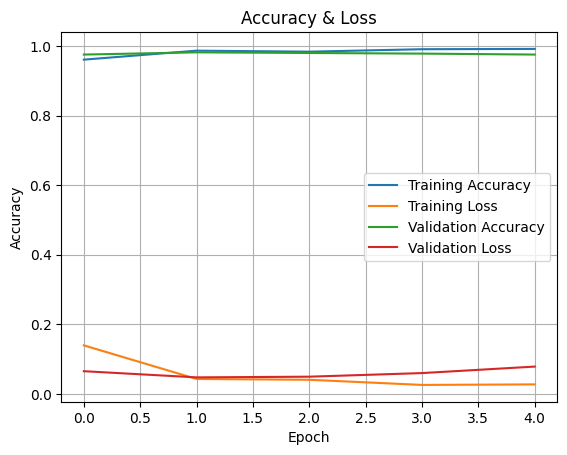

In [ ]:
import matplotlib.pyplot as plt
# Ambil data dari history
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot
plt.plot(acc, label='Training Accuracy')
plt.plot(loss, label='Training Loss')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(val_loss, label='Validation Loss')
plt.title('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

y_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()
y_true = test_generator.classes

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
img_path = '/content/fake-gan5.jfif'
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
prediction = model.predict(img_array)
predicted_label = 'real' if prediction[0][0] > 0.5 else 'fake'
print(f"Prediksi: {predicted_label} (probabilitas: {prediction[0][0]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediksi: fake (probabilitas: 0.0264)
